## Задание 2
Данные Immunotherapy.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency, ttest_ind, norm

sns.set(style="whitegrid", font="serif")

In [2]:
df = pd.read_excel('data/Immunotherapy.xlsx')
df

,sex,age,Time,Number_of_Warts,Type,Area,induration_diameter,Result_of_Treatment
0,1,22,2.25,14,3,51,50,1
1,1,15,3.00,2,3,900,70,1
2,1,16,10.50,2,1,100,25,1
3,1,27,4.50,9,3,80,30,1
4,1,20,8.00,6,1,45,8,1
...,...,...,...,...,...,...,...,...
85,1,40,5.50,8,3,69,5,1
86,1,38,7.50,8,2,56,45,1
87,1,46,11.50,4,1,91,25,0
88,1,32,12.00,9,1,43,50,0


### Basic EDA
Для изучения распределения данных посмотрим на pair plot.

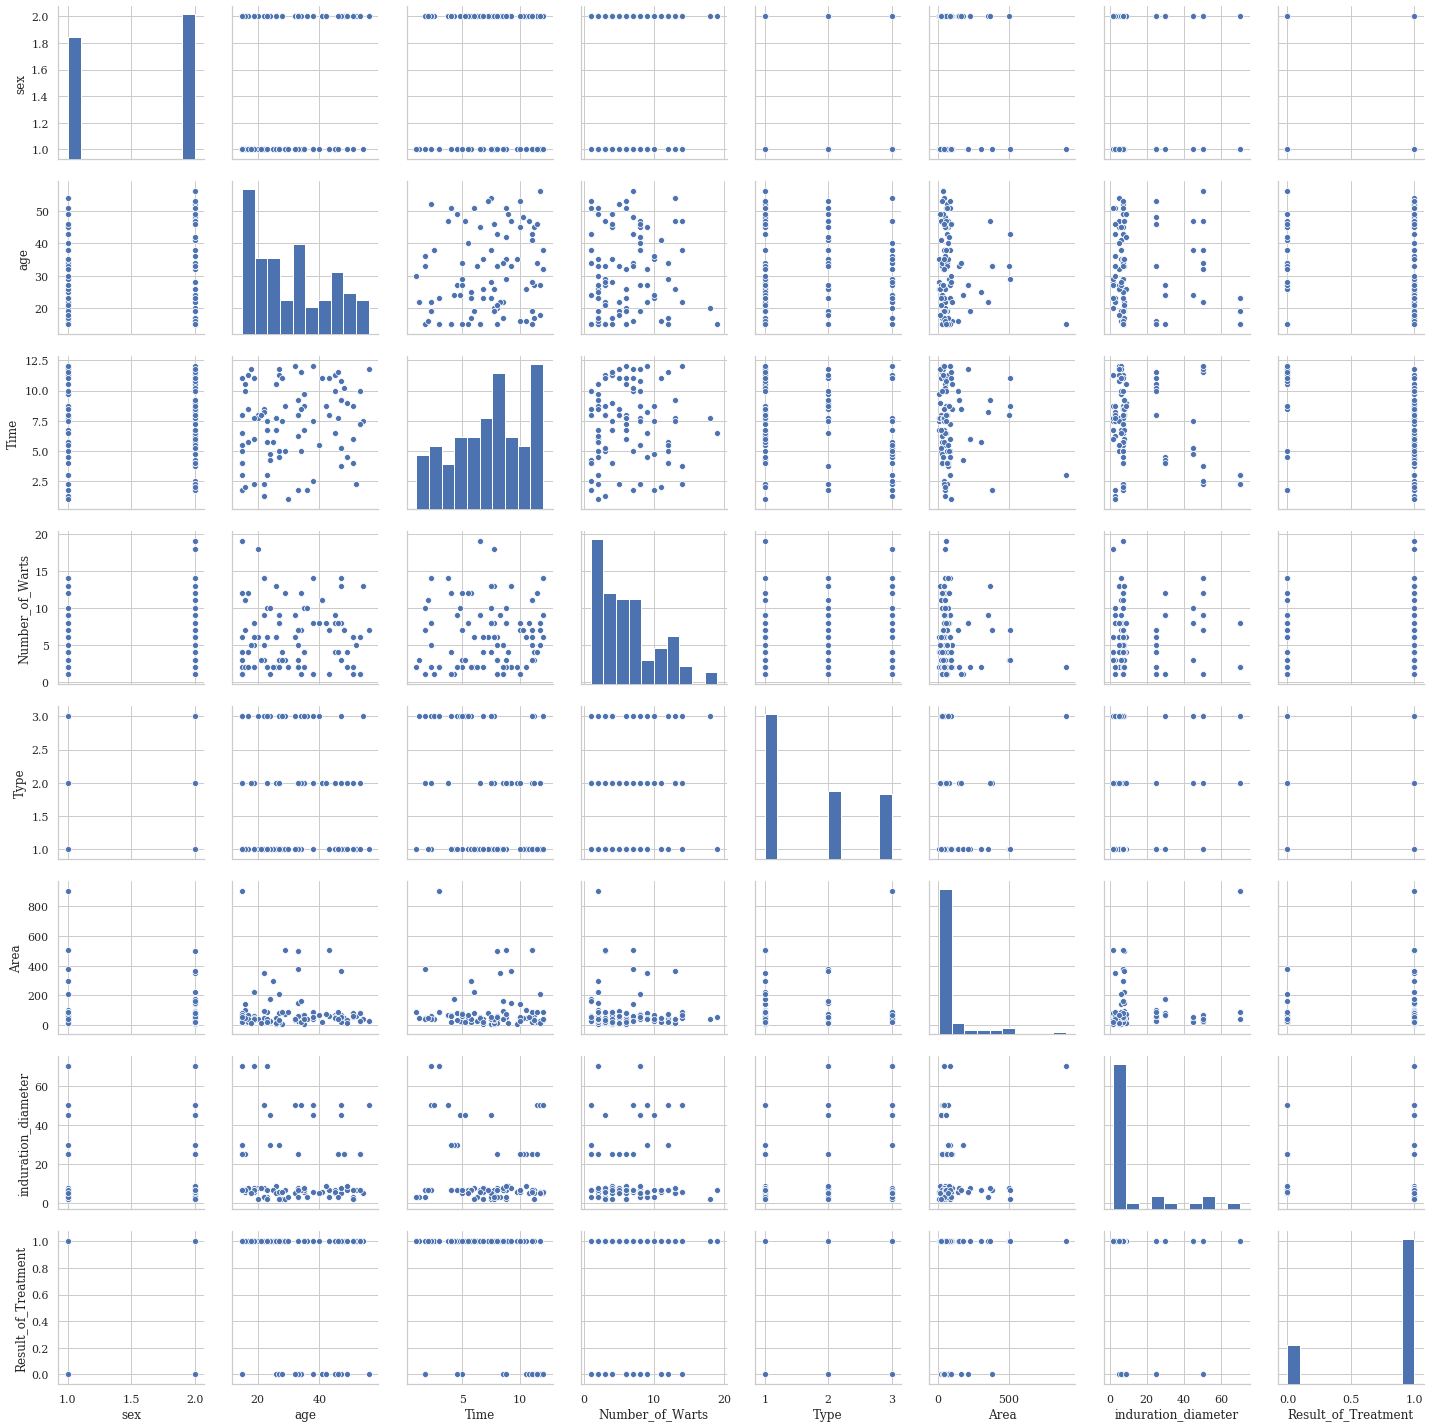

In [3]:
g = sns.pairplot(df)

### Проверка корректности тестов

In [4]:
print('pval of independed:', chi2_contingency([[100, 100], [100, 100]])[1])
print('pval of depended:', chi2_contingency([[100, 0], [0, 100]])[1])

print()

print('pval with equal averages:', ttest_ind(norm.rvs(0, 1, size=100), norm.rvs(0, 1, size=100))[1])
print('pval with unequal averages', ttest_ind(norm.rvs(0, 1, size=100), norm.rvs(42, 1, size=100))[1])

pval of independed: 1.0
pval of depended: 1.5431200214053197e-44

pval with equal averages: 0.5598362411915431
pval with unequal averages 2.201449410656635e-273


### Средние в группах

In [5]:
print('Means in untreated group:')
print(df[df['Result_of_Treatment'] == 0].mean())

print()

print('Means in treated group:')
print(df[df['Result_of_Treatment'] == 1].mean())

Means in untreated group:
sex                     1.526316
age                    35.473684
Time                    9.381579
Number_of_Warts         6.526316
Type                    1.578947
Area                   84.315789
induration_diameter    15.368421
Result_of_Treatment     0.000000
dtype: float64

Means in treated group:
sex                     1.549296
age                    29.859155
Time                    6.654930
Number_of_Warts         6.042254
Type                    1.746479
Area                   98.746479
induration_diameter    14.056338
Result_of_Treatment     1.000000
dtype: float64


### Множественная проверка гипотез
Всего в данной работе будет рассмотрено 7 гипотез. 
Будем ипользвавать **поправку Бонферони** для множественной проверки гипотез.

In [6]:
bonferroni_correction = 7

### Пол
Так как данные о поле дискретны, будем проверять гипозу "результат лечиния зависит от пола" с помощью критерия хи-квадрат для теста независимости. Не забудем проверить условие применения метода.

In [7]:
def test_dependency(column1, column2, alpha):
    table = np.array([[len(df[(df[column1] == c1) & (df[column2] == c2)]) 
                              for c1 in df[column1].unique()] 
                              for c2 in df[column2].unique()])
    # Application boundaries
    assert np.all(table >= 6)
    
    chi2, pval, dof, expected = chi2_contingency(table)
    return(pval > alpha)

In [8]:
alpha = 0.05 / bonferroni_correction
test_dependency('sex', 'Result_of_Treatment', alpha)

True

**Вывод**: гипотеза о независимости результатов лечения от пола не может быть отвергнута.

### Возраст

Будем использовать тот же критерий, но разобьем пациентов на группы по возрасту.

In [9]:
alpha = 0.05 / bonferroni_correction
df['age_group'] = np.digitize(df.age, [15, 33, 42, 60])
test_dependency('age_group', 'Result_of_Treatment', alpha)

True

**Вывод**: гипотеза о независимости результатов лечения от возраста не может быть отвергнута.

### Тип бородавки
Проверим зависит ли результат лечения от типа бородавки.

In [10]:
alpha = 0.05 / bonferroni_correction
test_dependency('sex', 'Type', alpha)

True

**Вывод**: гипотеза о независимости результатов лечения от типа бородавки не может быть отвергнута.

### Количество бородавок

Будем проверять гипотезу "среднее число борадавок одиноково при разных результатах лечения" против альтернативы "среднее число бородавок выше у тех, кому лечение не помогло" с помощью t-теста.

In [11]:
alpha = 0.05 / bonferroni_correction
stat, pval = ttest_ind(df[df.Result_of_Treatment == 0].Number_of_Warts, df[df.Result_of_Treatment == 1].Number_of_Warts)
pval > alpha

True

**Вывод**: Гипотеза о равестве среднего количества бородавок при разных результататах лечения не может быть отвергнута.

### Время до начала лечения

Будем проверять гипотезу "среднее время до начала лечения одиноково при разных результатах лечения" против альтернативы "среднее время до начала лечения больше у тех, кому лечение не помогло" с помощью t-теста.

In [12]:
alpha = 0.05 / bonferroni_correction
stat, pval = ttest_ind(df[df.Result_of_Treatment == 0].Time, df[df.Result_of_Treatment == 1].Time)
pval > alpha

False

**Вывод**: Гипотеза о равестве среднего временеи до начала лечения при разных результататах лечения может быть отвергнута.

### Размер бородавок
Будем проверять гипотезу "средний размер бородавок одиноков при разных результатах лечения" против альтернативы "средний размер бородавок больше у тех, кому лечение не помогло" с помощью t-теста.

In [13]:
alpha = 0.05 / bonferroni_correction
stat, pval = ttest_ind(df[df.Result_of_Treatment == 0].Area, df[df.Result_of_Treatment == 1].Area)
pval > alpha

True

**Вывод**: Гипотеза о равестве среднего размера бородавок при разных результататах лечения не может быть отвергнута.

### Диаметр уплотнения
Будем проверять гипотезу "средний диаметр уплотнения одиноков при разных результатах лечения" против альтернативы "средний диаметр уплотнения больше у тех, кому лечение не помогло" с помощью t-теста.

In [14]:
alpha = 0.05 / bonferroni_correction
stat, pval = ttest_ind(df[df.Result_of_Treatment == 0].induration_diameter, df[df.Result_of_Treatment == 1].induration_diameter)
pval > alpha

True

**Вывод**: Гипотеза о равестве среднего диаметра уплотнения при разных результататах лечения не может быть отвергнута.